In [1]:
import numpy as np
import pandas as pd
import pygmt as gmt
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/yohai/workspace/faultSlip/')
sys.path.append('/Users/yohai/workspace/GPS_processing/')
from utils import *
from faultSlip.inversion import Inversion


In [2]:
def get_disp():
    dip_slip = np.sin(np.radians(rake)) * slip
    strike_slip = np.cos(np.radians(rake)) * slip
    inv.solution = np.array([strike_slip, dip_slip])
    return inv.gps[0].save_model(inv.solution), inv
def get_plain_cords(inv):
    return np.stack([inv.plains[0].sources[0].p1, inv.plains[0].sources[0].p2, inv.plains[0].sources[0].p3, inv.plains[0].sources[0].p4])
def get_source_cords(s):
    plain_cords = np.stack([s.p1, s.p2, s.p3, s.p4])
    plain_cords_lat = origin_lat + m2dd(plain_cords[:, 1]*1e3)
    plain_cords_lon = origin_lon + m2dd(plain_cords[:, 0]*1e3, plain_cords_lat)
    return np.stack((plain_cords_lon, plain_cords_lat, plain_cords[:, 2])).T

In [3]:
xx = np.linspace(0, 100e3, 1000)
yy = np.linspace(0, 100e3, 1000)
X, Y = np.meshgrid(xx, yy)
tdf= pd.DataFrame(dict(x=X.flatten(), y=Y.flatten(), id=0,E=0,Se=0,N=0,Sn=0,U=0,Su=0, lon=X.flatten()*1e-3, lat=Y.flatten()*1e-3))

In [4]:
tdf.to_csv('ttt.csv')

# Normal faulting example
## strike 180
## dip 45
## dip element = 1

In [47]:
parms = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false
	},
"plains":
	{
	"plain1":
		{
		"dip":45,
		"strike":180,
		"plain_cord":[50, 50, 0.01],
		"plain_length":20,
		"width":[12],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":1,
		"dip_element":-1,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}
'''
with open('../off_seis_syn/params.json', 'w') as f:
    f.write(parms)
inv = Inversion('../off_seis_syn/params.json')
inv.solution = np.array([0, 1.0])
strike_slip = np.array([0.0])
inv.build_kers()
inv.build_sources_mat()
plain_cords = get_plain_cords(inv)
disp = inv.gps[0].save_model(inv.solution)
da = xr.DataArray(
    data=disp.Up.values.reshape(X.shape),
    dims=['y', 'x'],
    coords=dict(
        y=(['y'], yy*1e-3),
        x=(['x'], xx*1e-3)
    )
)

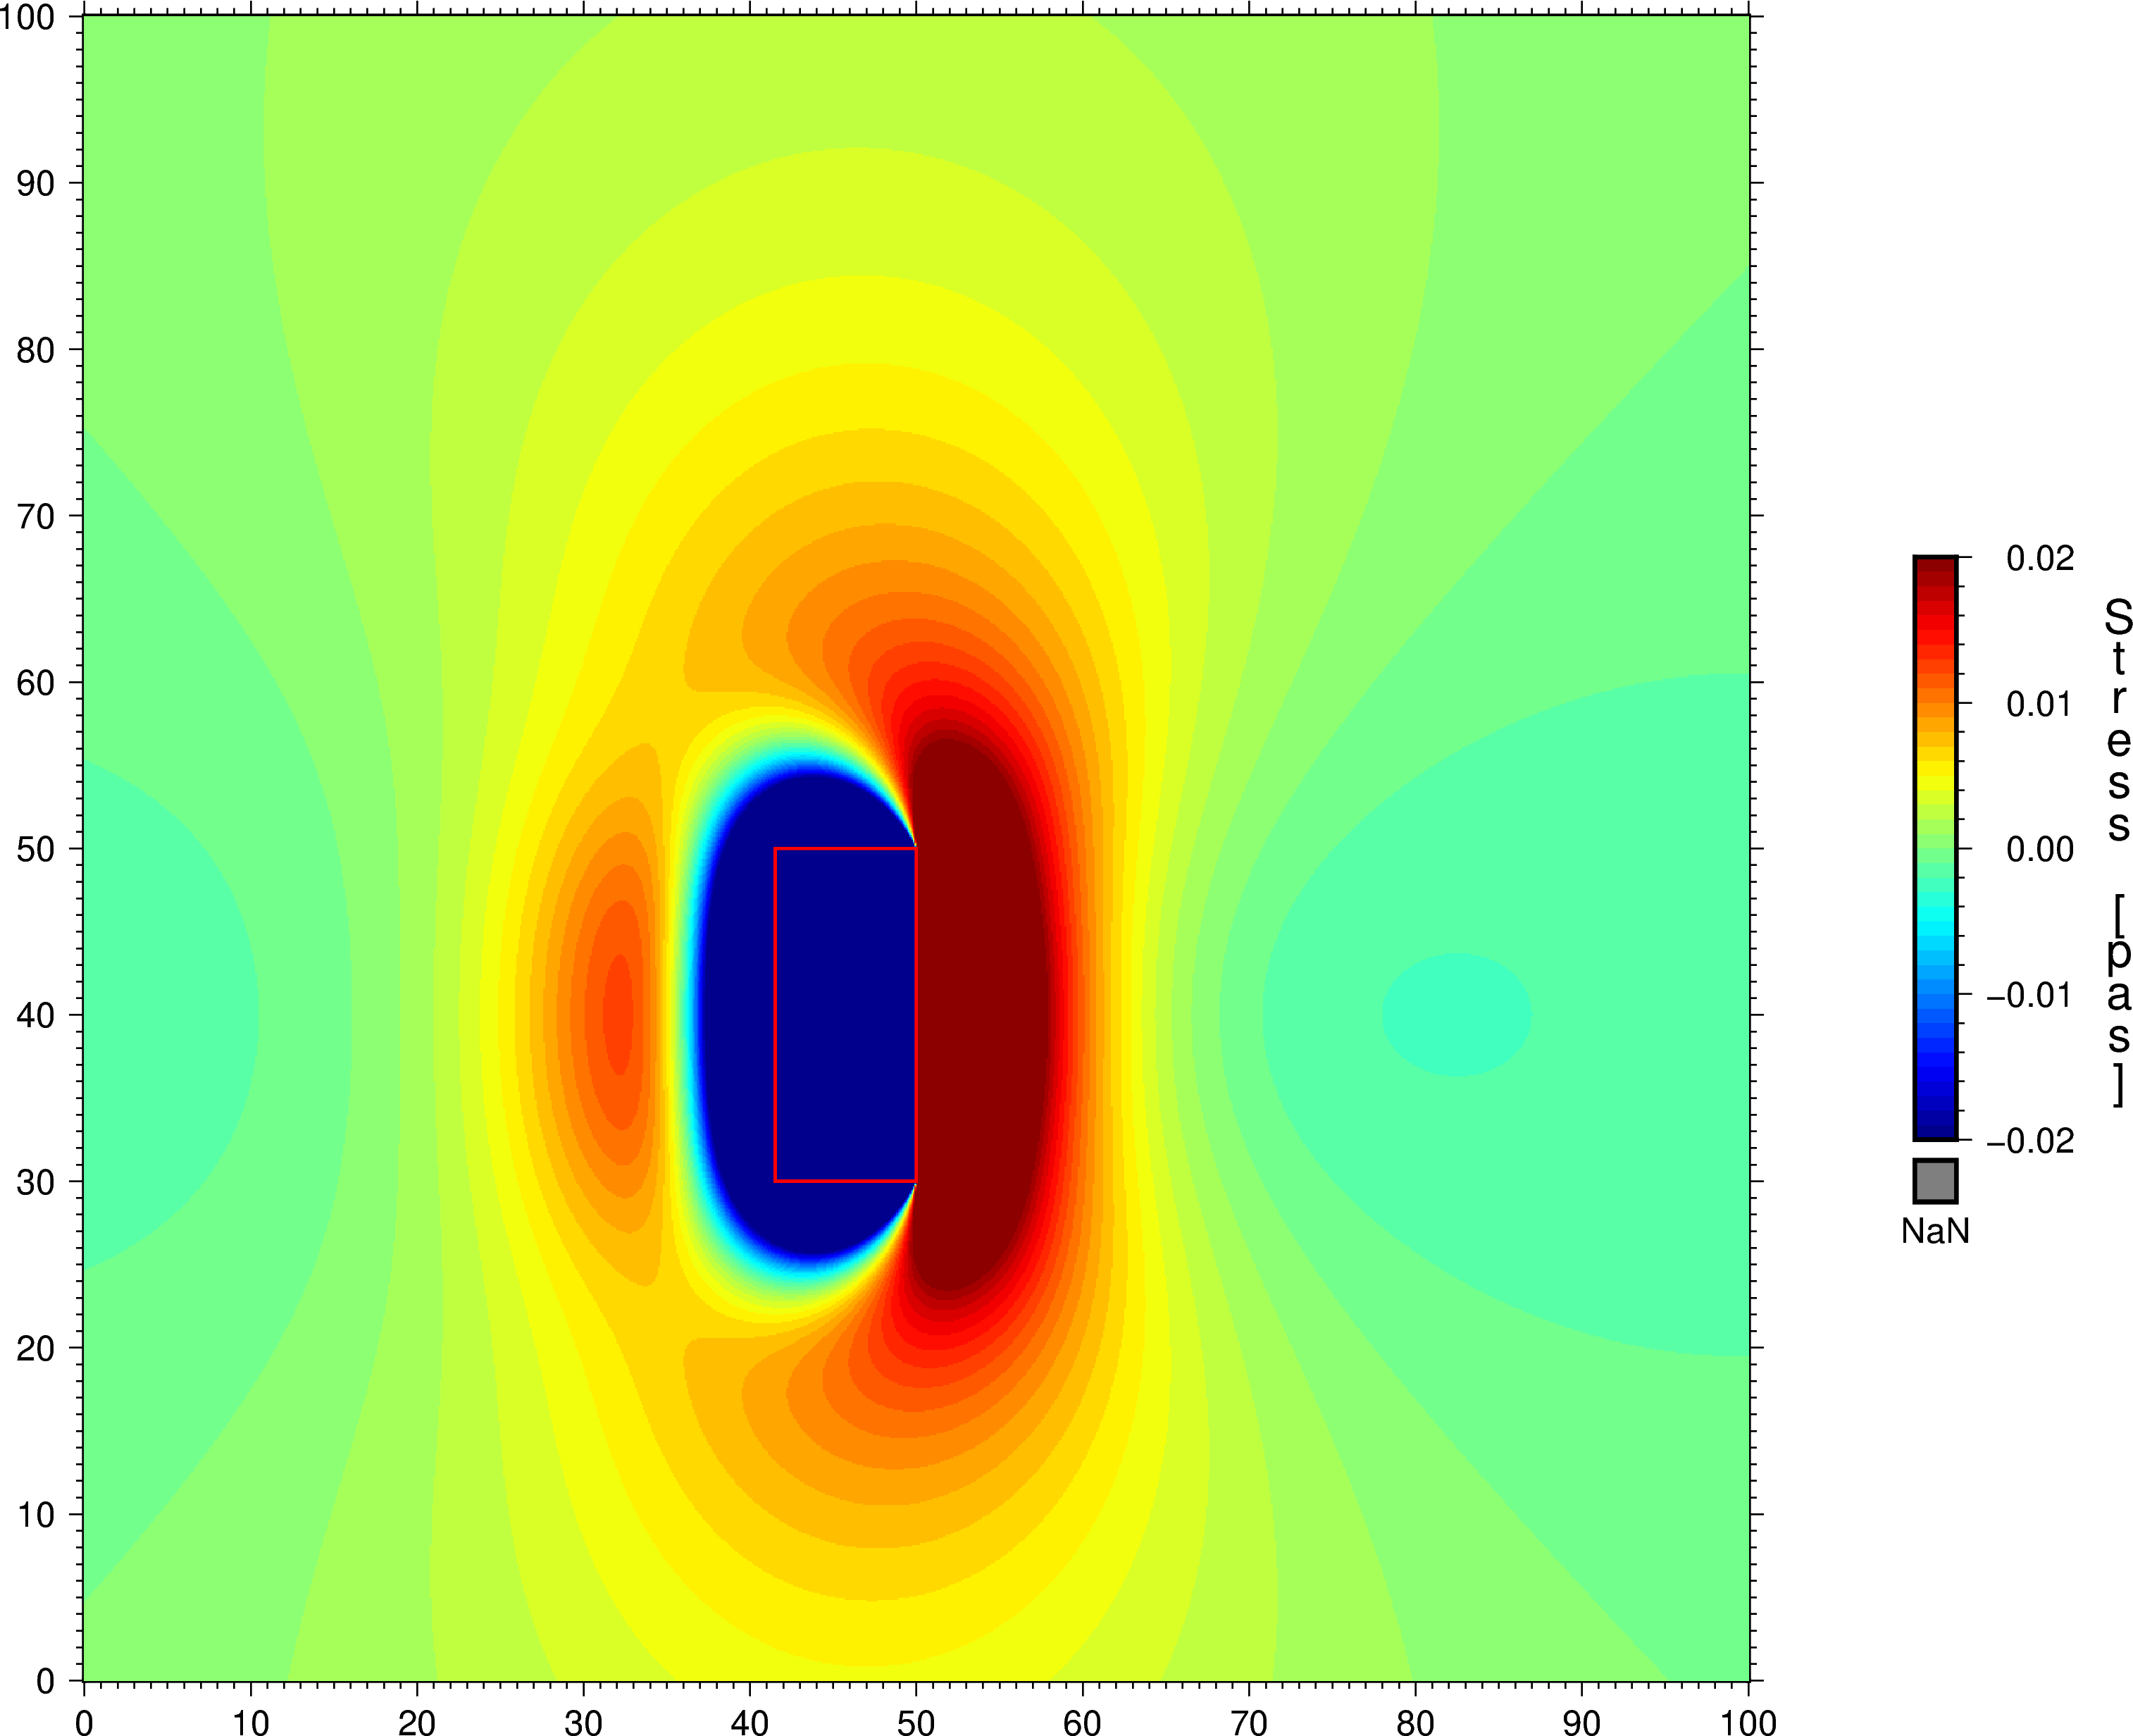

In [48]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')
region=[0, 100, 0, 100]
fig.basemap(
    B=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
pygmt.makecpt(cmap="jet", series=[-0.02, 0.02, 0.001], background=True)

fig.grdimage(grid=da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,red',
    L=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c+n+mc", frame='af+l"Stress [pas]"')

fig.show(width=600)

## calculating the stress on the same orentaion (dip:45 strike:180)
## rake:-90 represent normal faulting

In [25]:
X1, Y1 = np.meshgrid(np.linspace(0, 100, 200), np.linspace(0, 100, 200))
Z1 = np.ones_like(X1) * 0.1
dip = 45
strike = 180#plain.strike
# print plain.dip, plain.strike
b = inv.calc_coulomb_2d(0.4, X1, Y1, Z1, rake=np.deg2rad(-90), strike=np.deg2rad(strike), dip=np.deg2rad(dip))
normal_da = xr.DataArray(
    data=b[4],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X1[0, :]),
        y=(['y'], Y1[:, 0])
    )
)
shear_da = xr.DataArray(
    data=b[5],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X1[0, :]),
        y=(['y'], Y1[:, 0])
    )
)
coulomb_da = xr.DataArray(
    data=b[3],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X1[0, :]),
        y=(['y'], Y1[:, 0])
    )
)

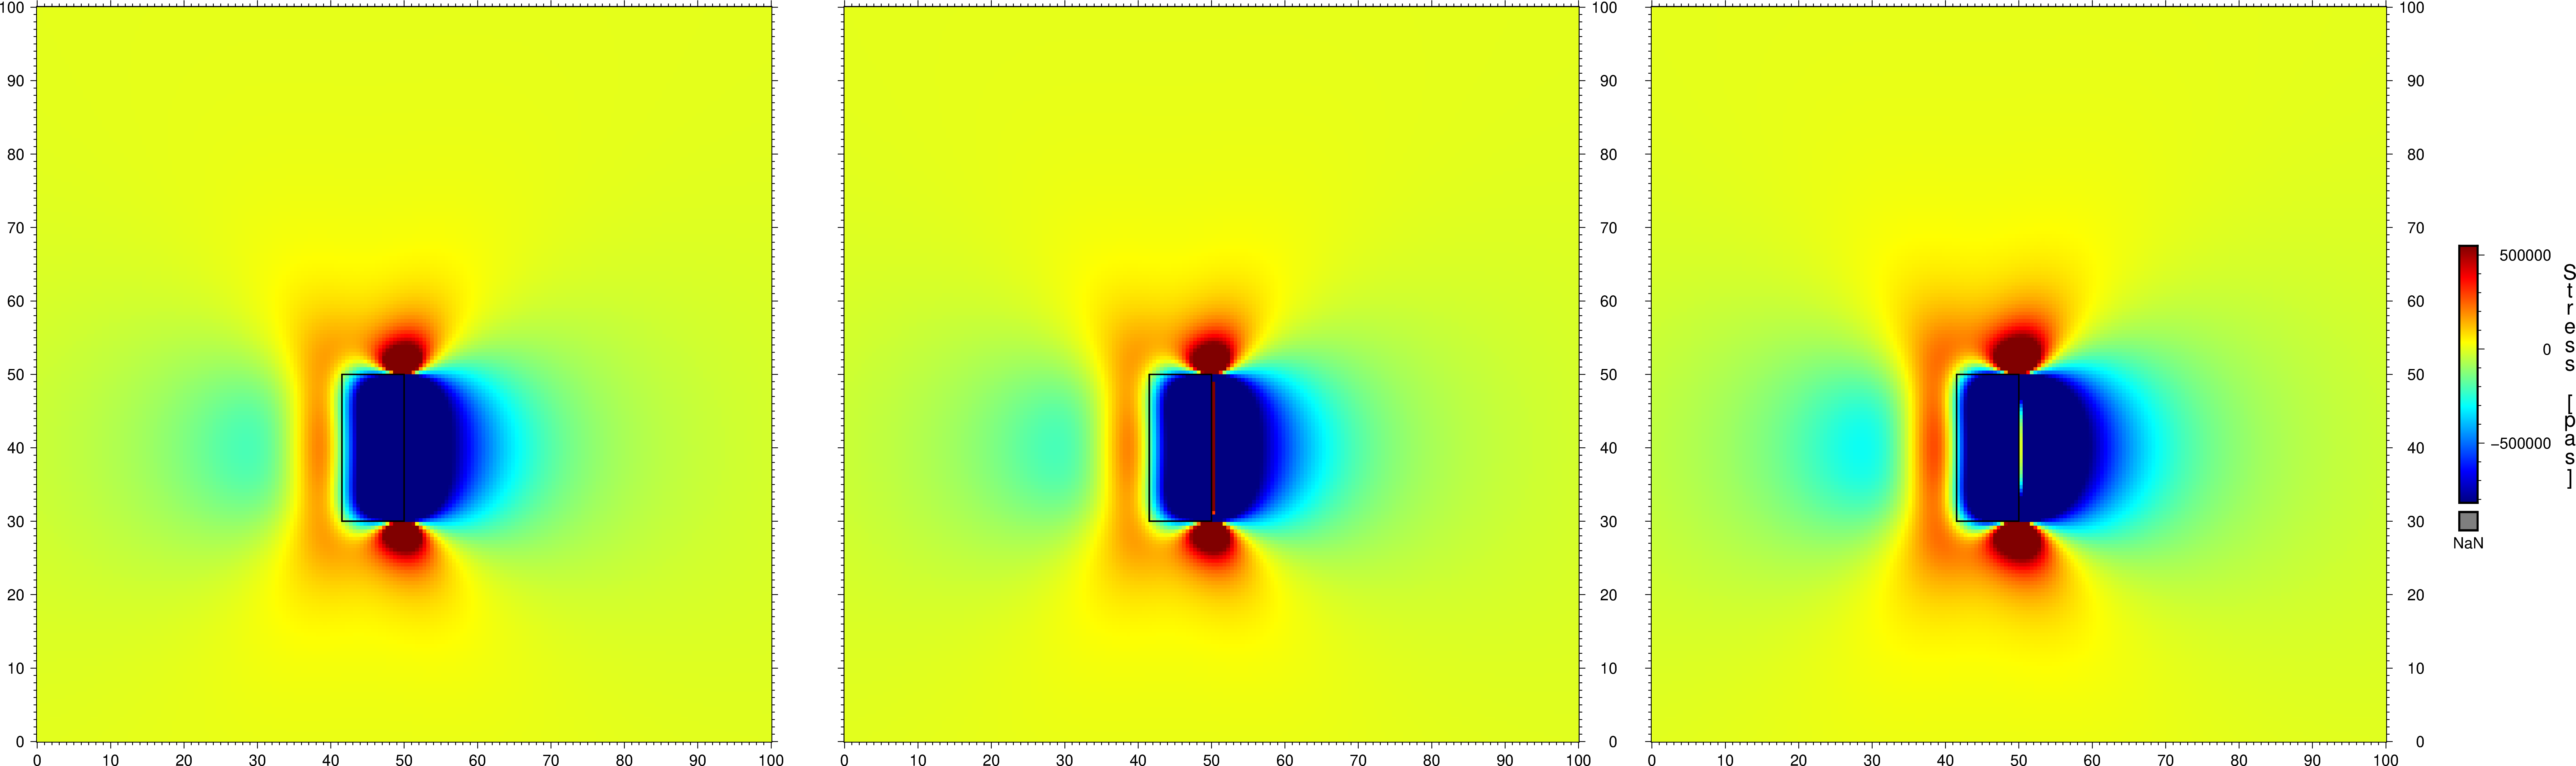

In [26]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = float(shear_da.max().data) * 0.05
mmin = float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="jet", series=[mmin,mmax, (mmax - mmin) / 1000], background=True)

fig.grdimage(grid=shear_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,black',
    L=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=normal_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,black',
    L=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,black',
    L=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c+n+mc", frame='af+l"Stress [pas]"')

fig.show(width=1200)

## A cross section view

In [37]:
X1, Z1 = np.meshgrid(np.linspace(0, 100, 200), np.linspace(0, 20, 200))
Y1 = np.ones_like(X1) * 40
# plain = inv.images[0].plains[5]
dip = 45#plain.dip
strike = 180#plain.strike
# print plain.dip, plain.strike
a = inv.calc_coulomb_2d(0.0, X1, Y1, Z1, rake=np.deg2rad(-90), strike=np.deg2rad(strike), dip=np.deg2rad(dip))

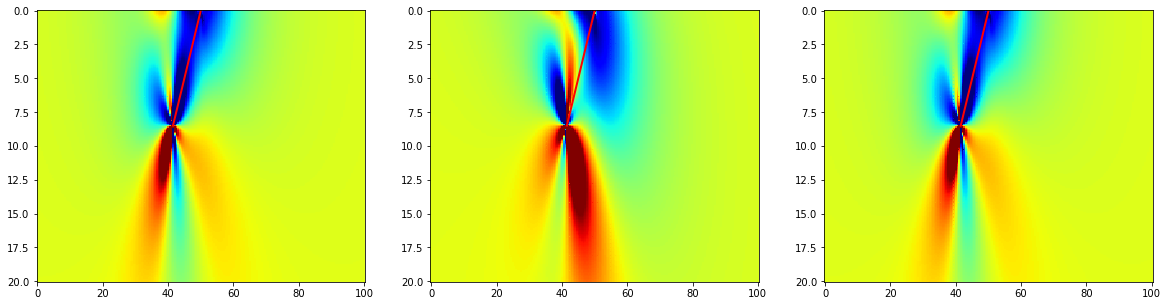

In [44]:
mmax = a[5].max() * 0.05
mmin = a[5].min() * 0.05
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ax = axs[0]
ax.pcolormesh(X1, Z1, a[5], vmin=mmin, vmax=mmax, cmap='jet', shading='auto')
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot(plain_cords[[0, 2], 0], plain_cords[[0, 2], 2], lw=2, color='r')
ax = axs[1]
ax.pcolormesh(X1, Z1, a[4], vmin=mmin, vmax=mmax, cmap='jet', shading='auto')
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot(plain_cords[[0, 2], 0], plain_cords[[0, 2], 2], lw=2, color='r')
ax = axs[2]
ax.pcolormesh(X1, Z1, a[3], vmin=mmin, vmax=mmax, cmap='jet', shading='auto')
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot(plain_cords[[0, 2], 0], plain_cords[[0, 2], 2], lw=2, color='r')

# Reverse faulting example
## strike 180
## dip 45
## dip element = 1

In [49]:
parms = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false
	},
"plains":
	{
	"plain1":
		{
		"dip":45,
		"strike":180,
		"plain_cord":[50, 50, 0.01],
		"plain_length":20,
		"width":[12],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":1,
		"dip_element":1,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}
'''
with open('../off_seis_syn/params.json', 'w') as f:
    f.write(parms)
inv = Inversion('../off_seis_syn/params.json')
inv.solution = np.array([0, 1.0])
strike_slip = np.array([0.0])
inv.build_kers()
inv.build_sources_mat()
plain_cords = get_plain_cords(inv)
disp = inv.gps[0].save_model(inv.solution)
da = xr.DataArray(
    data=disp.Up.values.reshape(X.shape),
    dims=['y', 'x'],
    coords=dict(
        y=(['y'], yy*1e-3),
        x=(['x'], xx*1e-3)
    )
)

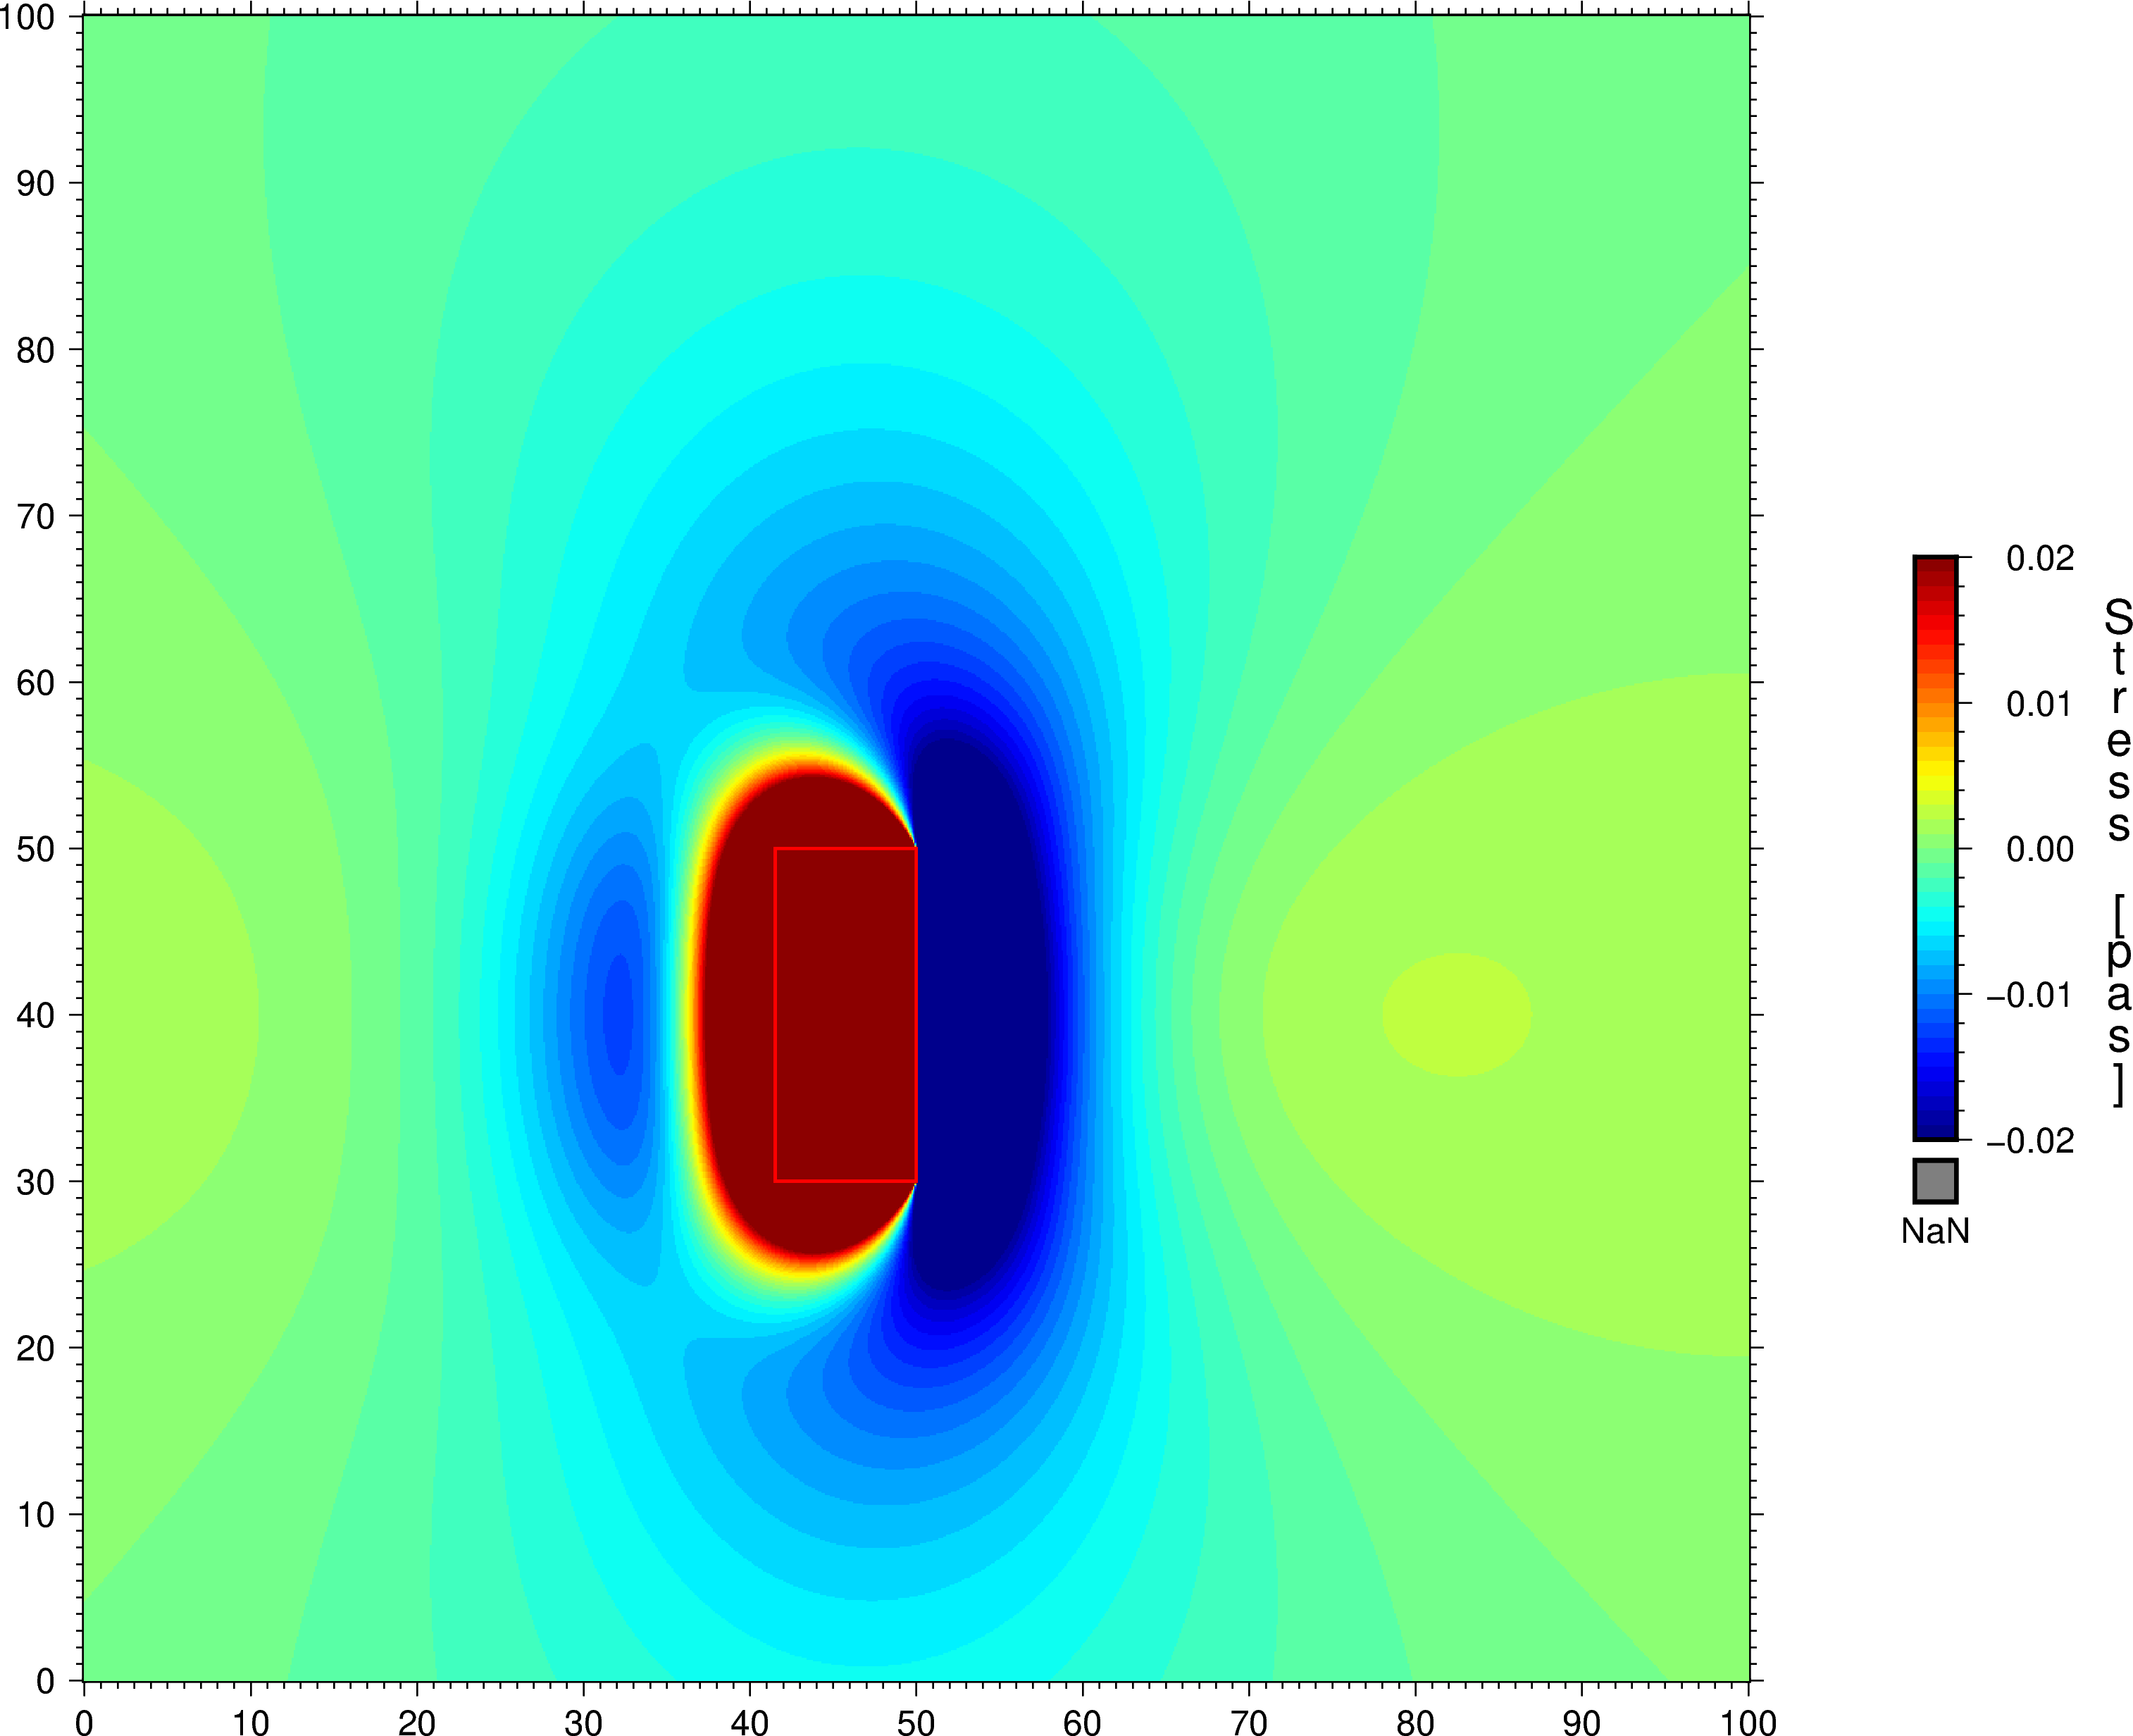

In [50]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')
region=[0, 100, 0, 100]
fig.basemap(
    B=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
pygmt.makecpt(cmap="jet", series=[-0.02, 0.02, 0.001], background=True)

fig.grdimage(grid=da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,red',
    L=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c+n+mc", frame='af+l"Stress [pas]"')

fig.show(width=600)

## calculating the stress on the same orentaion (dip:45 strike:180)
## rake:90 represent reverse faulting

In [51]:
X1, Y1 = np.meshgrid(np.linspace(0, 100, 200), np.linspace(0, 100, 200))
Z1 = np.ones_like(X1) * 0.1
dip = 45
strike = 180#plain.strike
# print plain.dip, plain.strike
b = inv.calc_coulomb_2d(0.4, X1, Y1, Z1, rake=np.deg2rad(90), strike=np.deg2rad(strike), dip=np.deg2rad(dip))
normal_da = xr.DataArray(
    data=b[4],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X1[0, :]),
        y=(['y'], Y1[:, 0])
    )
)
shear_da = xr.DataArray(
    data=b[5],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X1[0, :]),
        y=(['y'], Y1[:, 0])
    )
)
coulomb_da = xr.DataArray(
    data=b[3],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X1[0, :]),
        y=(['y'], Y1[:, 0])
    )
)

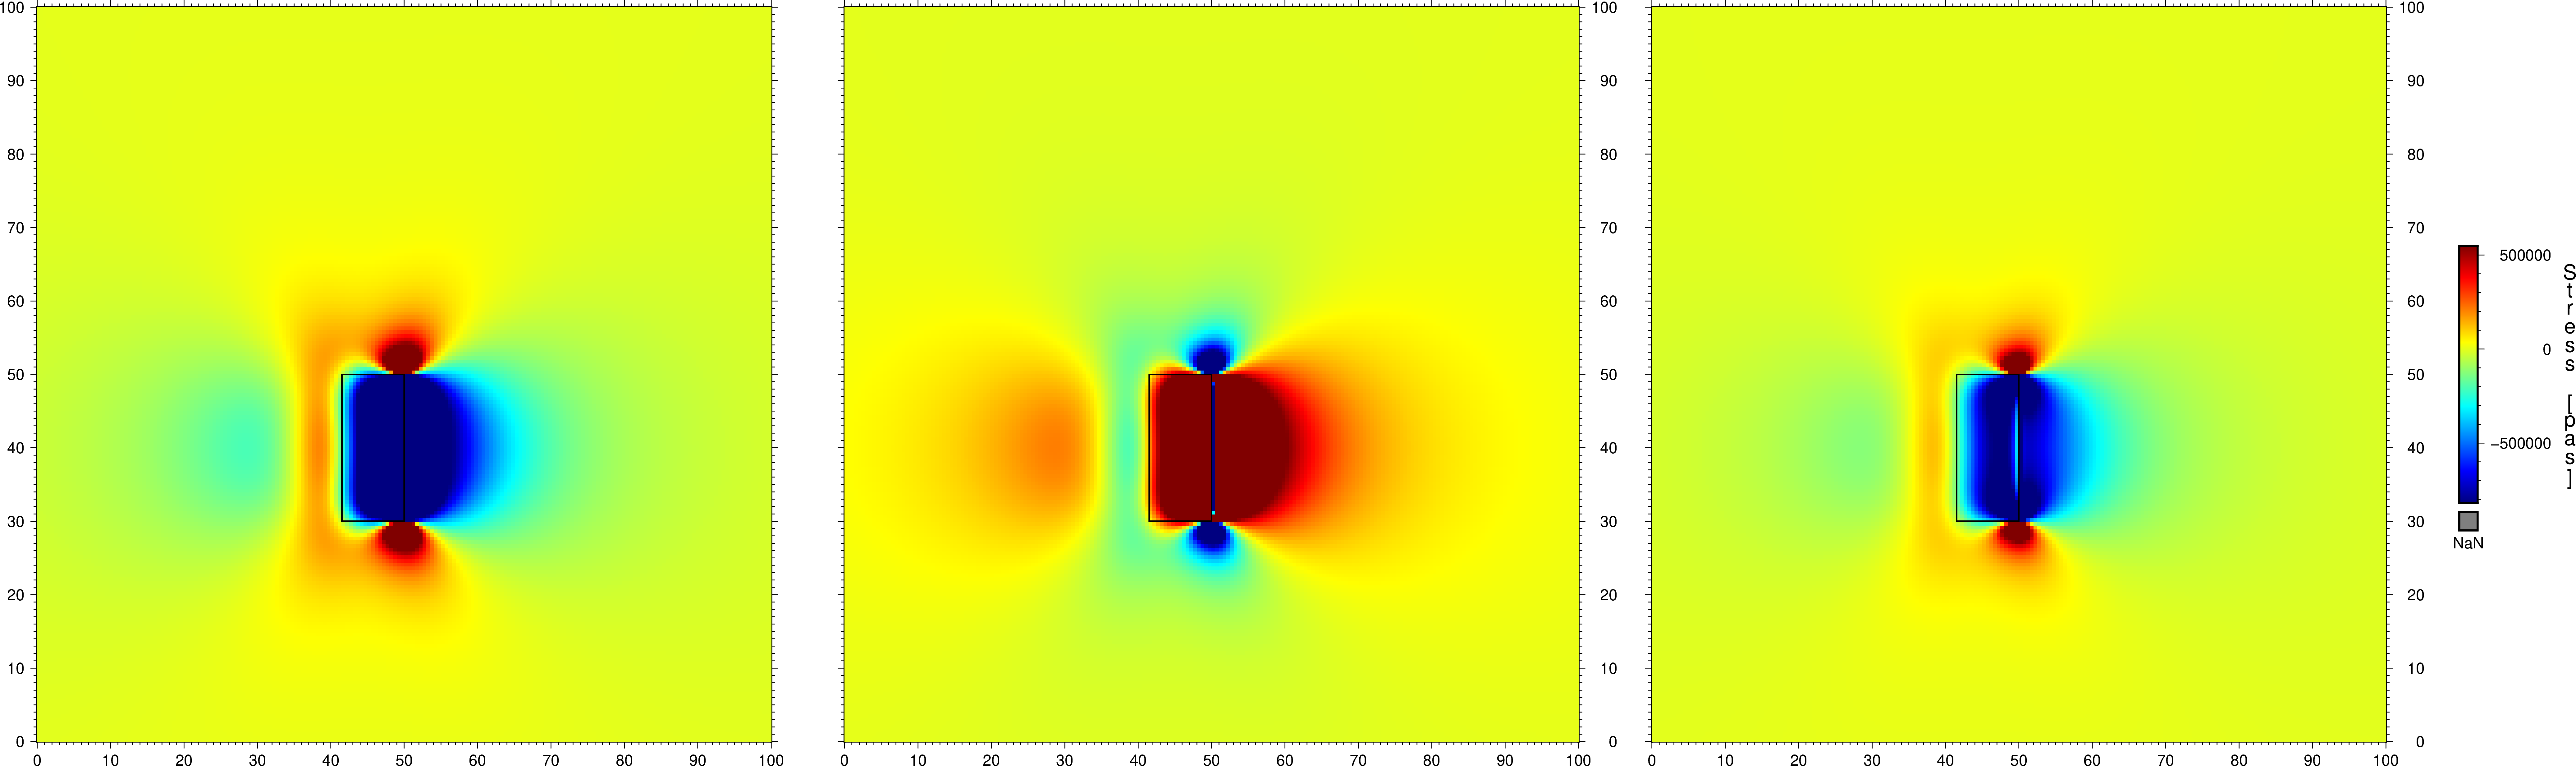

In [52]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = float(shear_da.max().data) * 0.05
mmin = float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="jet", series=[mmin,mmax, (mmax - mmin) / 1000], background=True)

fig.grdimage(grid=shear_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,black',
    L=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=normal_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,black',
    L=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,black',
    L=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c+n+mc", frame='af+l"Stress [pas]"')

fig.show(width=1200)

## A cross section view

In [53]:
X1, Z1 = np.meshgrid(np.linspace(0, 100, 200), np.linspace(0, 20, 200))
Y1 = np.ones_like(X1) * 40
# plain = inv.images[0].plains[5]
dip = 45#plain.dip
strike = 180#plain.strike
# print plain.dip, plain.strike
a = inv.calc_coulomb_2d(0.0, X1, Y1, Z1, rake=np.deg2rad(90), strike=np.deg2rad(strike), dip=np.deg2rad(dip))

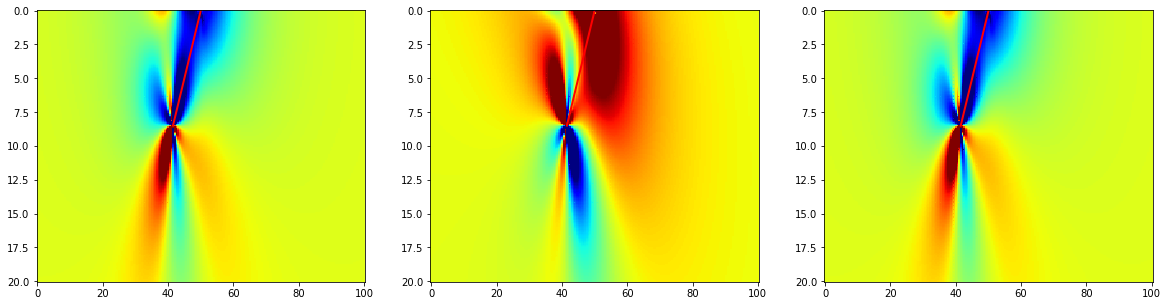

In [54]:
mmax = a[5].max() * 0.05
mmin = a[5].min() * 0.05
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ax = axs[0]
ax.pcolormesh(X1, Z1, a[5], vmin=mmin, vmax=mmax, cmap='jet', shading='auto')
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot(plain_cords[[0, 2], 0], plain_cords[[0, 2], 2], lw=2, color='r')
ax = axs[1]
ax.pcolormesh(X1, Z1, a[4], vmin=mmin, vmax=mmax, cmap='jet', shading='auto')
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot(plain_cords[[0, 2], 0], plain_cords[[0, 2], 2], lw=2, color='r')
ax = axs[2]
ax.pcolormesh(X1, Z1, a[3], vmin=mmin, vmax=mmax, cmap='jet', shading='auto')
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot(plain_cords[[0, 2], 0], plain_cords[[0, 2], 2], lw=2, color='r')

# Right lateral strike slip movment
## strike 180
## dip 90
## strike element -1

In [61]:
parms = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false
	},
"plains":
	{
	"plain1":
		{
		"dip":90,
		"strike":180,
		"plain_cord":[50, 50, 0.01],
		"plain_length":20,
		"width":[12],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":-1,
		"dip_element":1,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}
'''
with open('../off_seis_syn/params.json', 'w') as f:
    f.write(parms)
inv = Inversion('../off_seis_syn/params.json')
inv.solution = np.array([1.0, 0.0])
inv.build_kers()
inv.build_sources_mat()
plain_cords = get_plain_cords(inv)
disp = inv.gps[0].save_model(inv.solution)
da = xr.DataArray(
    data=disp.Up.values.reshape(X.shape),
    dims=['y', 'x'],
    coords=dict(
        y=(['y'], yy*1e-3),
        x=(['x'], xx*1e-3)
    )
)

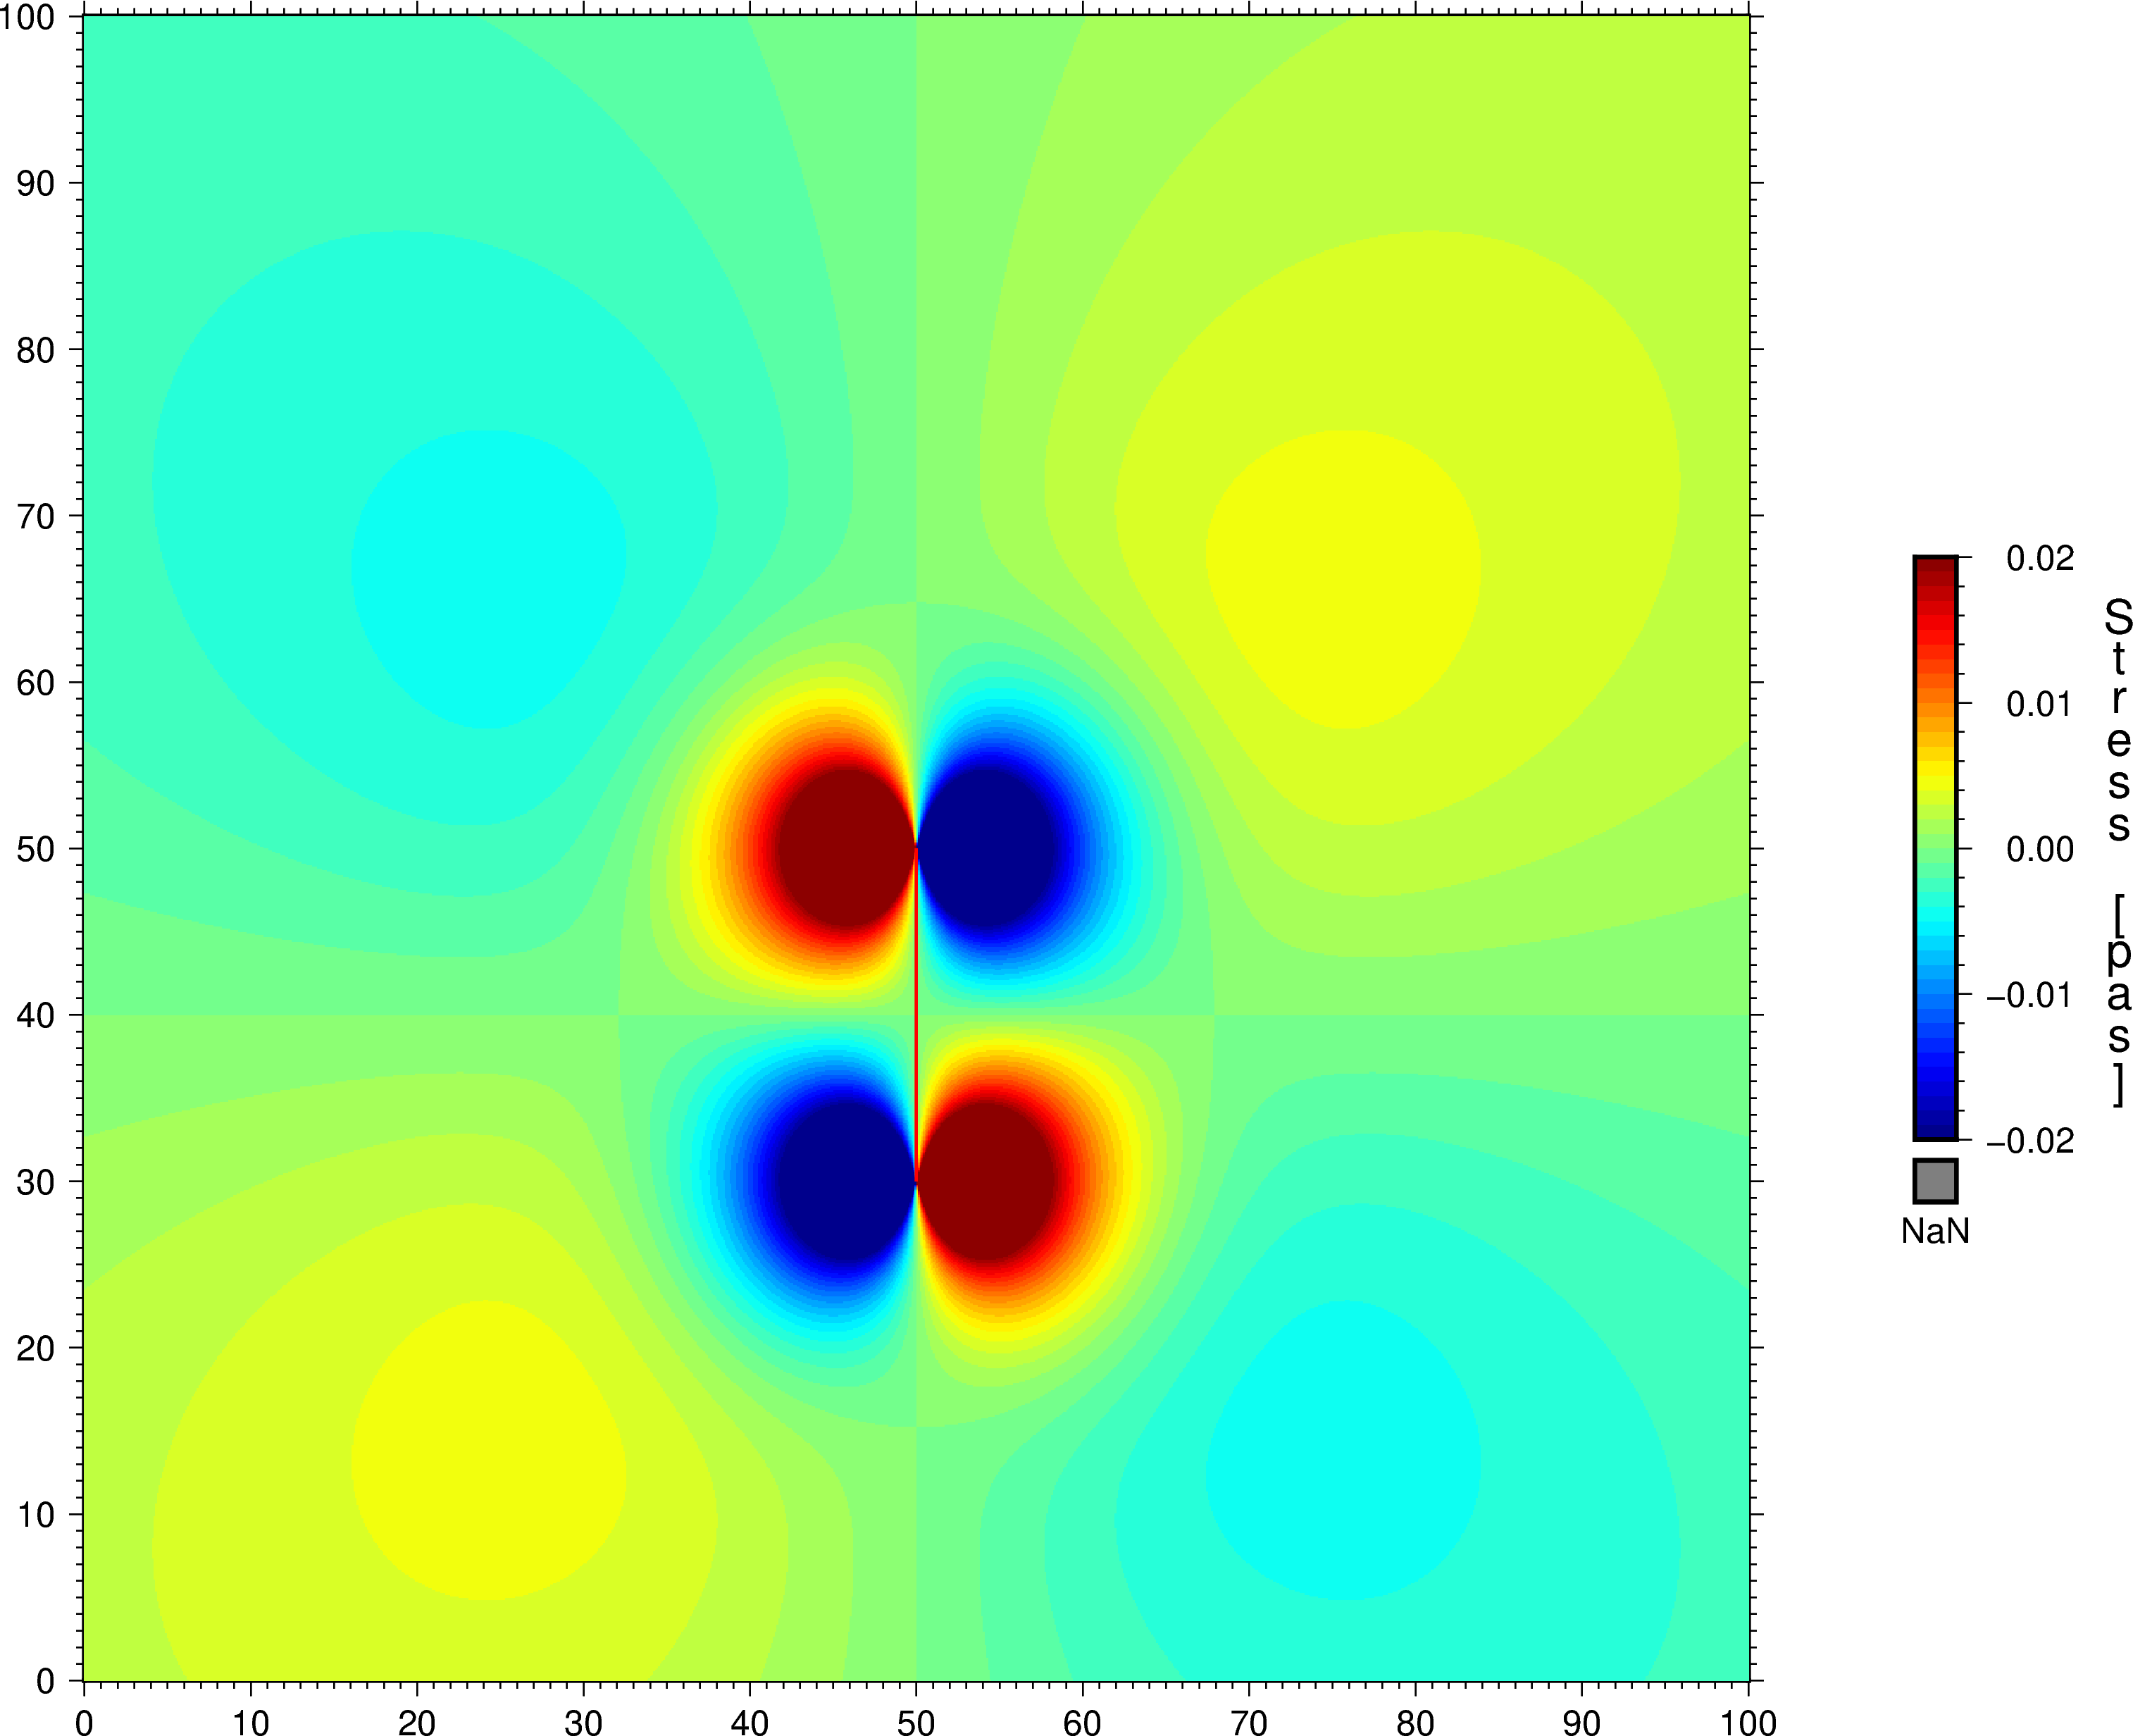

In [62]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')
region=[0, 100, 0, 100]
fig.basemap(
    B=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
pygmt.makecpt(cmap="jet", series=[-0.02, 0.02, 0.001], background=True)

fig.grdimage(grid=da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,red',
    L=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c+n+mc", frame='af+l"Stress [pas]"')

fig.show(width=600)

## calculating the stress on the same orentaion (dip:90 strike:180)
## rake:0 represent right lateral movment

In [63]:
X1, Y1 = np.meshgrid(np.linspace(0, 100, 200), np.linspace(0, 100, 200))
Z1 = np.ones_like(X1) * 0.1
dip = 90
strike = 180#plain.strike
# print plain.dip, plain.strike
b = inv.calc_coulomb_2d(0.4, X1, Y1, Z1, rake=np.deg2rad(0), strike=np.deg2rad(strike), dip=np.deg2rad(dip))
normal_da = xr.DataArray(
    data=b[4],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X1[0, :]),
        y=(['y'], Y1[:, 0])
    )
)
shear_da = xr.DataArray(
    data=b[5],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X1[0, :]),
        y=(['y'], Y1[:, 0])
    )
)
coulomb_da = xr.DataArray(
    data=b[3],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X1[0, :]),
        y=(['y'], Y1[:, 0])
    )
)

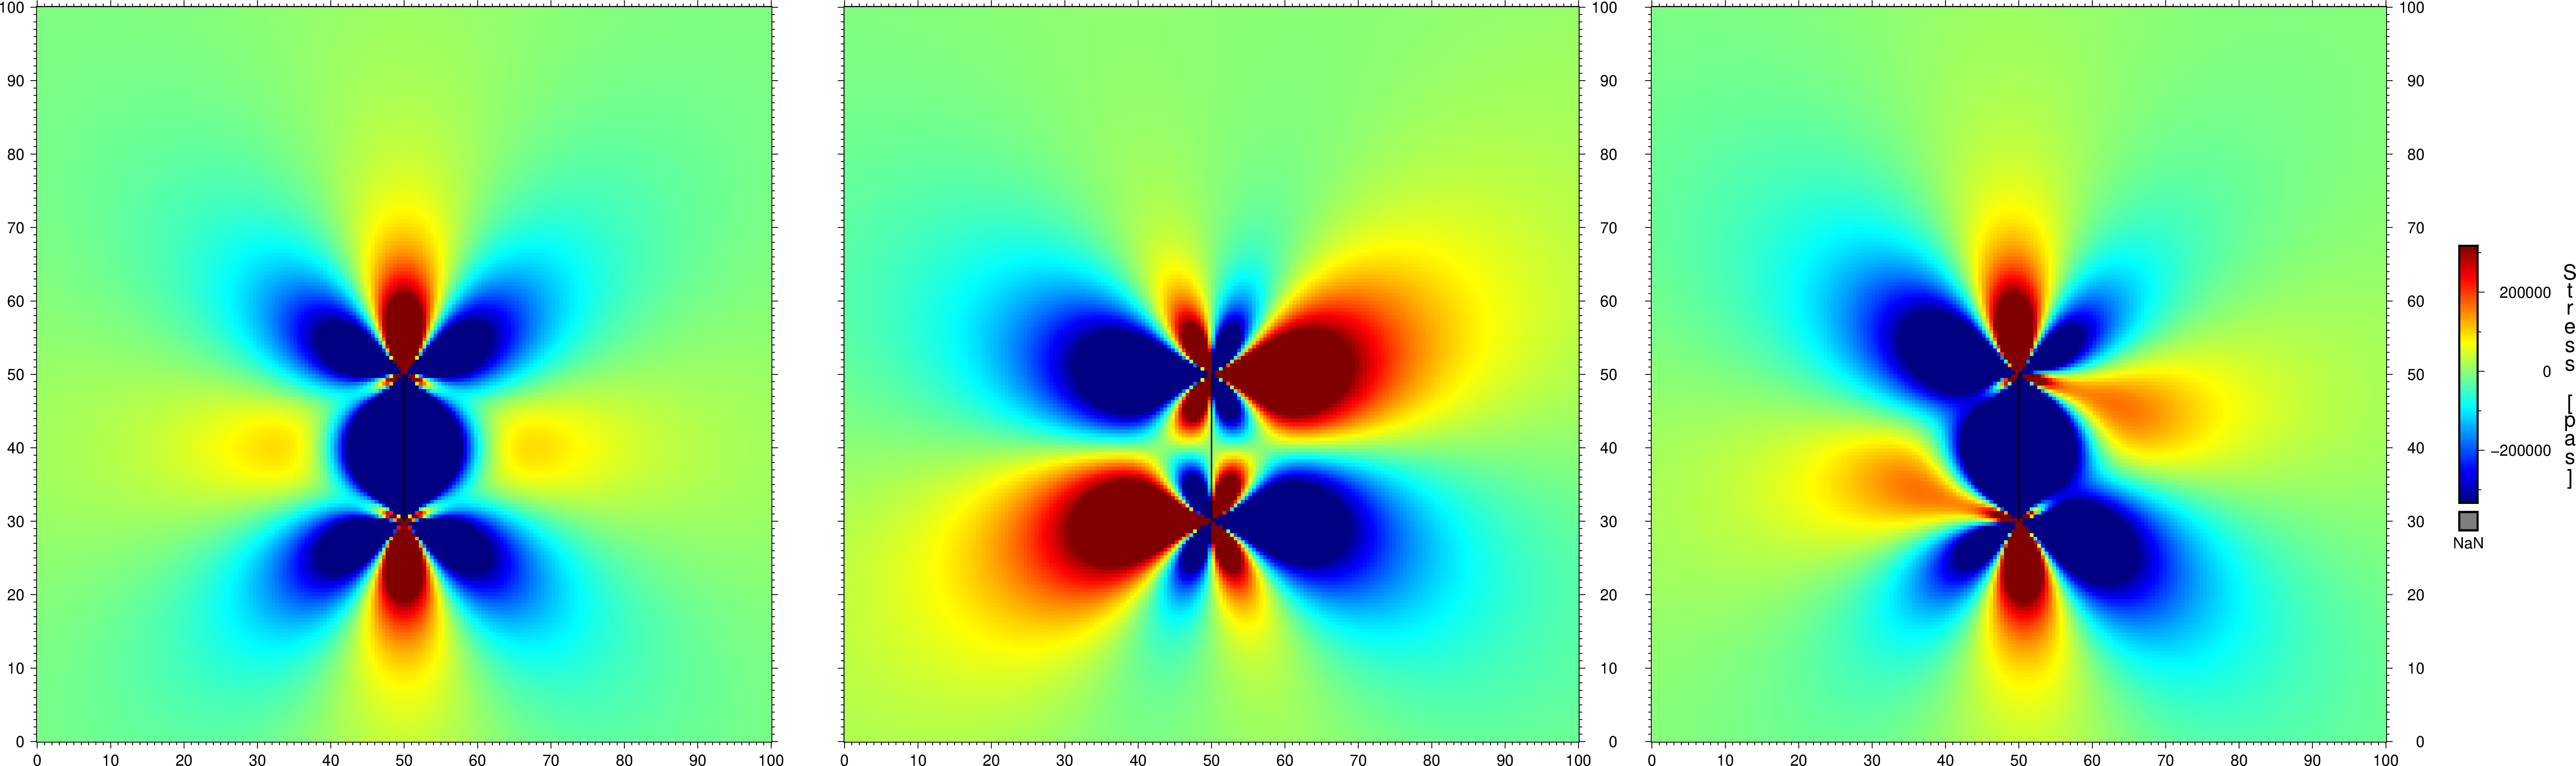

In [64]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = float(shear_da.max().data) * 0.05
mmin = float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="jet", series=[mmin,mmax, (mmax - mmin) / 1000], background=True)

fig.grdimage(grid=shear_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,black',
    L=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=normal_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,black',
    L=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,black',
    L=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c+n+mc", frame='af+l"Stress [pas]"')

fig.show(width=1200)

## A cross section view

In [65]:
X1, Z1 = np.meshgrid(np.linspace(0, 100, 200), np.linspace(0, 20, 200))
Y1 = np.ones_like(X1) * 40
# plain = inv.images[0].plains[5]
dip = 90
strike = 180#plain.strike
# print plain.dip, plain.strike
a = inv.calc_coulomb_2d(0.0, X1, Y1, Z1, rake=np.deg2rad(0), strike=np.deg2rad(strike), dip=np.deg2rad(dip))

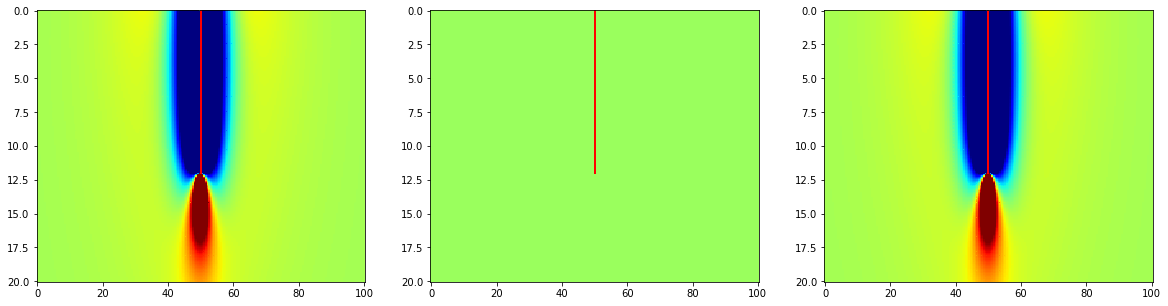

In [66]:
mmax = a[5].max() * 0.05
mmin = a[5].min() * 0.05
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ax = axs[0]
ax.pcolormesh(X1, Z1, a[5], vmin=mmin, vmax=mmax, cmap='jet', shading='auto')
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot(plain_cords[[0, 2], 0], plain_cords[[0, 2], 2], lw=2, color='r')
ax = axs[1]
ax.pcolormesh(X1, Z1, a[4], vmin=mmin, vmax=mmax, cmap='jet', shading='auto')
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot(plain_cords[[0, 2], 0], plain_cords[[0, 2], 2], lw=2, color='r')
ax = axs[2]
ax.pcolormesh(X1, Z1, a[3], vmin=mmin, vmax=mmax, cmap='jet', shading='auto')
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot(plain_cords[[0, 2], 0], plain_cords[[0, 2], 2], lw=2, color='r')

# Left lateral strike slip movment
## strike 180
## dip 90
## strike element 1

In [67]:
parms = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false
	},
"plains":
	{
	"plain1":
		{
		"dip":90,
		"strike":180,
		"plain_cord":[50, 50, 0.01],
		"plain_length":20,
		"width":[12],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":1,
		"dip_element":1,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}
'''
with open('../off_seis_syn/params.json', 'w') as f:
    f.write(parms)
inv = Inversion('../off_seis_syn/params.json')
inv.solution = np.array([1.0, 0.0])
inv.build_kers()
inv.build_sources_mat()
plain_cords = get_plain_cords(inv)
disp = inv.gps[0].save_model(inv.solution)
da = xr.DataArray(
    data=disp.Up.values.reshape(X.shape),
    dims=['y', 'x'],
    coords=dict(
        y=(['y'], yy*1e-3),
        x=(['x'], xx*1e-3)
    )
)

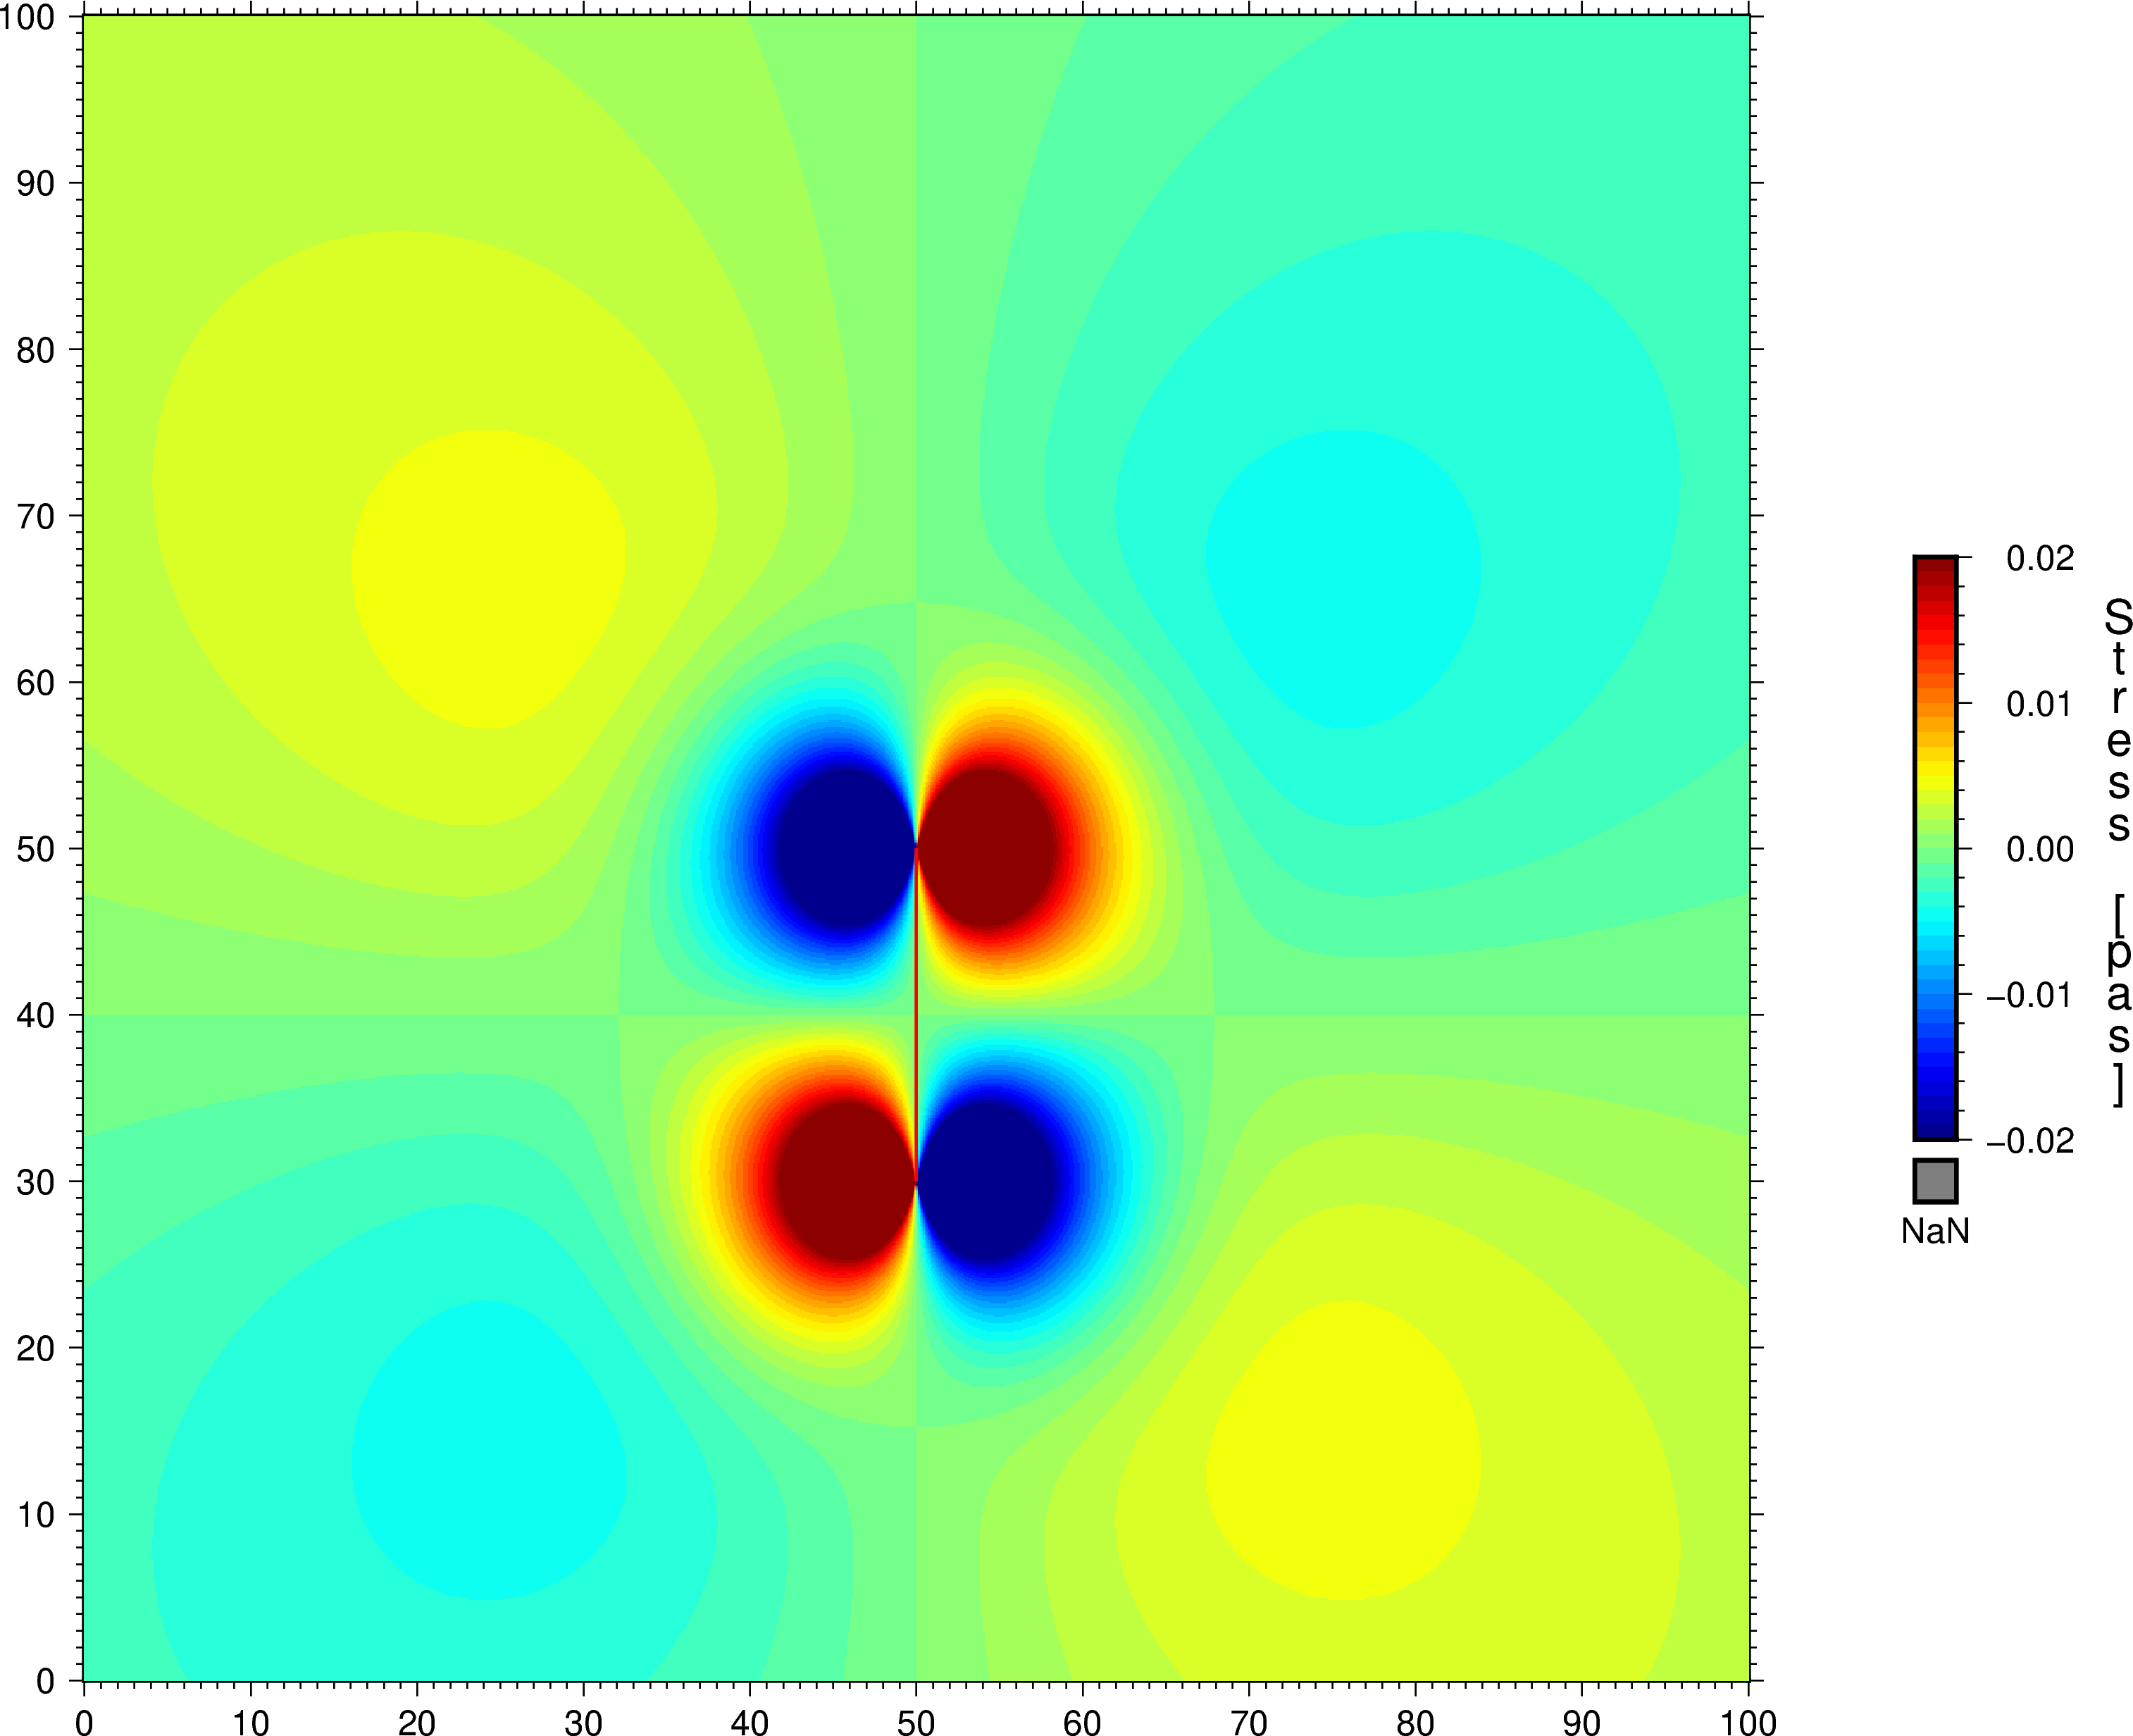

In [68]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')
region=[0, 100, 0, 100]
fig.basemap(
    B=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
pygmt.makecpt(cmap="jet", series=[-0.02, 0.02, 0.001], background=True)

fig.grdimage(grid=da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,red',
    L=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c+n+mc", frame='af+l"Stress [pas]"')

fig.show(width=600)

## calculating the stress on the same orentaion (dip:90 strike:180)
## rake:180 represent left lateral movment

In [69]:
X1, Y1 = np.meshgrid(np.linspace(0, 100, 200), np.linspace(0, 100, 200))
Z1 = np.ones_like(X1) * 0.1
dip = 90
strike = 180#plain.strike
# print plain.dip, plain.strike
b = inv.calc_coulomb_2d(0.4, X1, Y1, Z1, rake=np.deg2rad(180), strike=np.deg2rad(strike), dip=np.deg2rad(dip))
normal_da = xr.DataArray(
    data=b[4],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X1[0, :]),
        y=(['y'], Y1[:, 0])
    )
)
shear_da = xr.DataArray(
    data=b[5],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X1[0, :]),
        y=(['y'], Y1[:, 0])
    )
)
coulomb_da = xr.DataArray(
    data=b[3],
    dims=['y', 'x'],
    coords=dict(
        x=(['x'], X1[0, :]),
        y=(['y'], Y1[:, 0])
    )
)

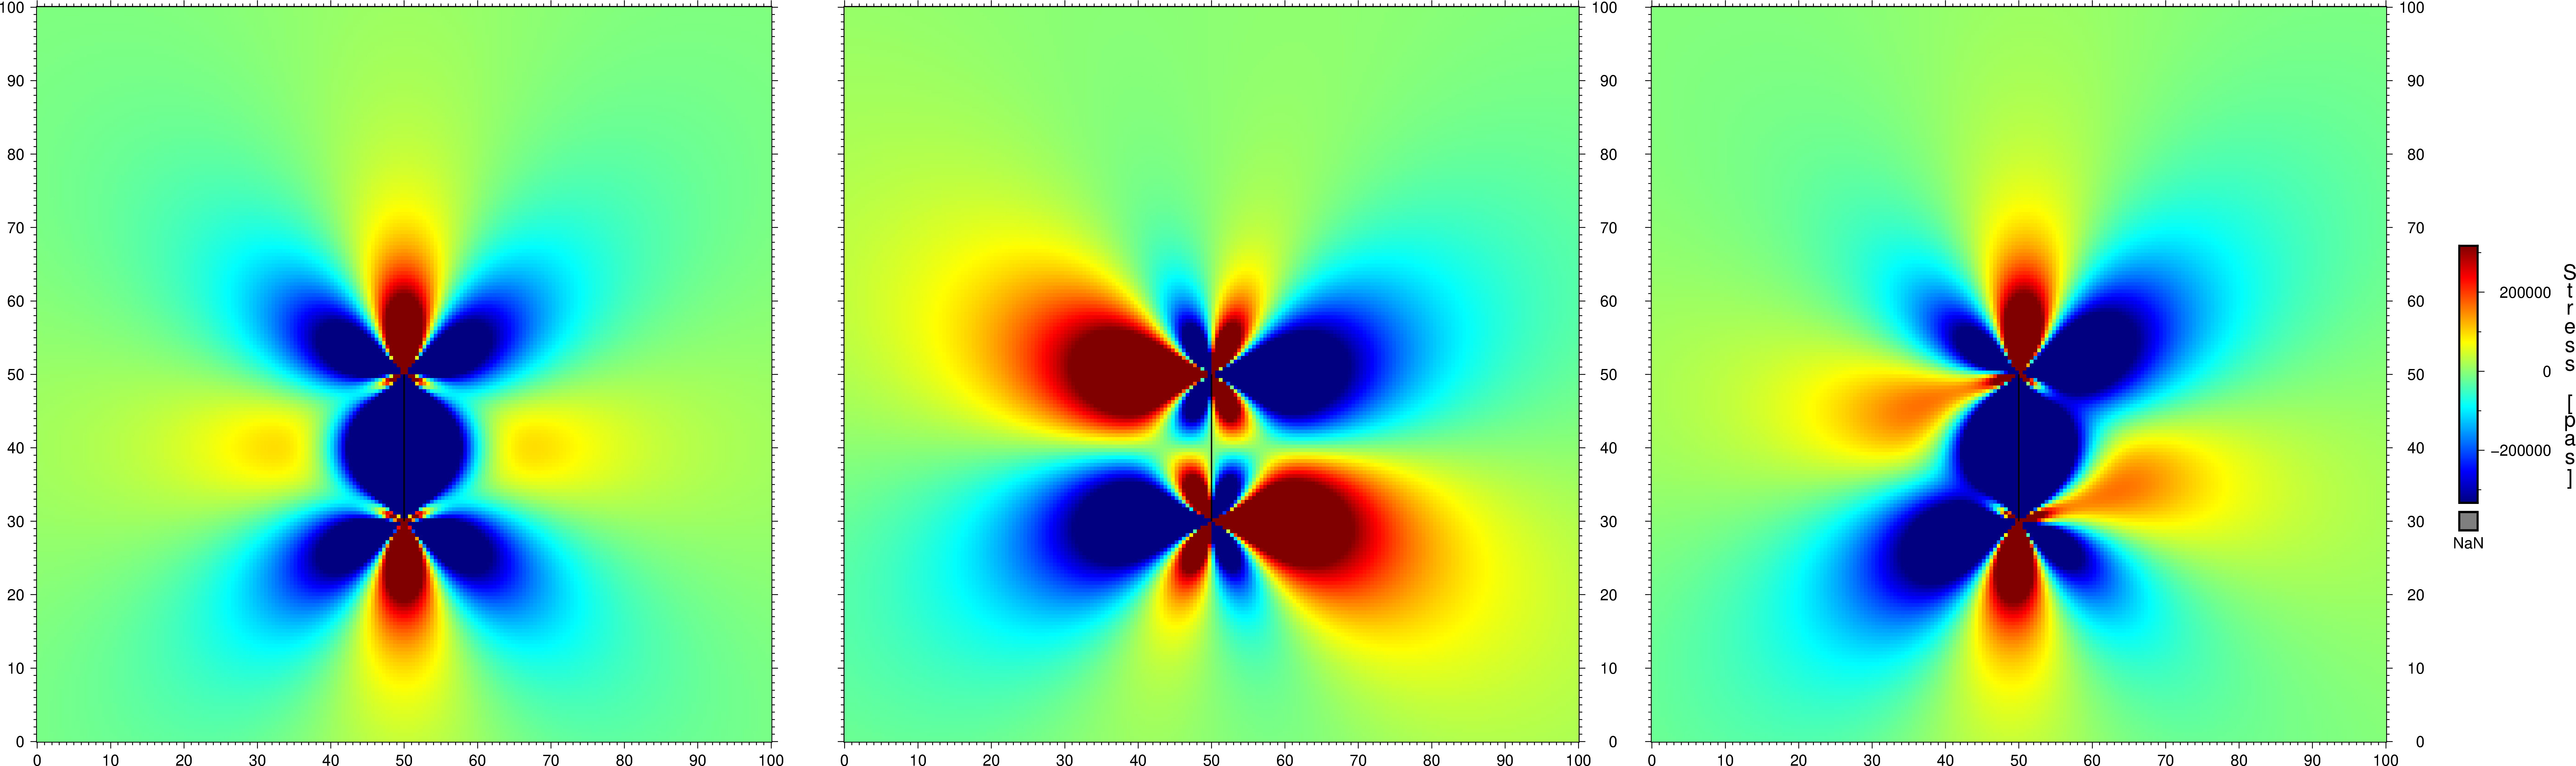

In [70]:
fig = gmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = float(shear_da.max().data) * 0.05
mmin = float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="jet", series=[mmin,mmax, (mmax - mmin) / 1000], background=True)

fig.grdimage(grid=shear_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,black',
    L=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=normal_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,black',
    L=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    W='1,black',
    L=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c+n+mc", frame='af+l"Stress [pas]"')

fig.show(width=1200)

## A cross section view

In [71]:
X1, Z1 = np.meshgrid(np.linspace(0, 100, 200), np.linspace(0, 20, 200))
Y1 = np.ones_like(X1) * 40
# plain = inv.images[0].plains[5]
dip = 90
strike = 180#plain.strike
# print plain.dip, plain.strike
a = inv.calc_coulomb_2d(0.0, X1, Y1, Z1, rake=np.deg2rad(180), strike=np.deg2rad(strike), dip=np.deg2rad(dip))

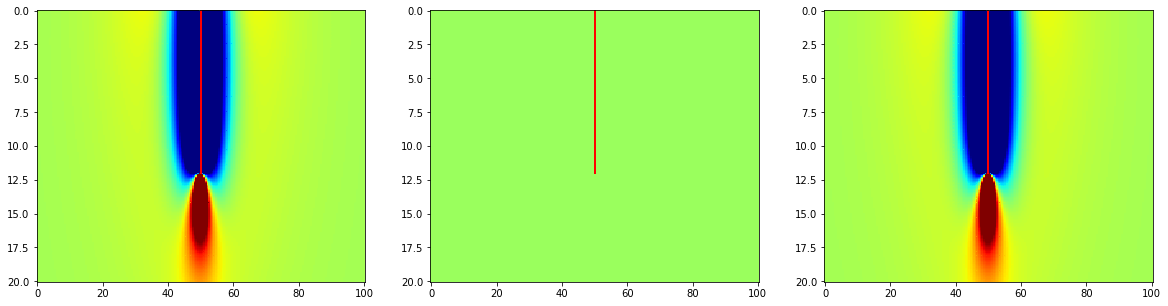

In [72]:
mmax = a[5].max() * 0.05
mmin = a[5].min() * 0.05
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ax = axs[0]
ax.pcolormesh(X1, Z1, a[5], vmin=mmin, vmax=mmax, cmap='jet', shading='auto')
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot(plain_cords[[0, 2], 0], plain_cords[[0, 2], 2], lw=2, color='r')
ax = axs[1]
ax.pcolormesh(X1, Z1, a[4], vmin=mmin, vmax=mmax, cmap='jet', shading='auto')
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot(plain_cords[[0, 2], 0], plain_cords[[0, 2], 2], lw=2, color='r')
ax = axs[2]
ax.pcolormesh(X1, Z1, a[3], vmin=mmin, vmax=mmax, cmap='jet', shading='auto')
ax.set_ylim(ax.get_ylim()[::-1])
ax.plot(plain_cords[[0, 2], 0], plain_cords[[0, 2], 2], lw=2, color='r')